In [ ]:
# default_exp processing

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
from sklearn import cluster
import scipy.ndimage as ndimage
import scipy.signal as signal
import scipy as sp
from cmath import *
import itertools
import random

from theonerig.core import *
from theonerig.utils import *
from theonerig.modelling import *

In [ ]:
#export
def eyetrack_stim_inten(stim_inten, eye_track, 
                        upsampling=2,
                        eye_calib=[[94 ,8], [ 18, 59]],
                        box_w=None, box_h=None, stim_axis="x"):
    """From stimulus data and eye tracking, returns a corrected and upsampled stimulus data."""
    eye_x, eye_y = eye_track[:,0], eye_track[:,1]
    shape_y, shape_x = 1, 1
    if len(stim_inten.shape)==2:
        if stim_axis=="x":
            shape_x = stim_inten.shape[1]
        elif stim_axis=="y":
            shape_y = stim_inten.shape[1]
    elif len(stim_inten.shape)==3:
        shape_y = stim_inten.shape[1]
        shape_x = stim_inten.shape[2]
    if box_w is None:
        box_w = 1280//shape_x
    if box_h is None:
        box_h = 720//shape_y

    if shape_y>1 and shape_x>1:
        box_w, box_h = int(box_w/upsampling), int(box_h/upsampling)
    elif shape_x > 1:
        box_w, box_h = int(box_w/upsampling), box_h
    elif shape_y > 1:
        box_w, box_h = box_w                , int(box_h/upsampling)

    eye_transfo_f = _eye_to_stim_f(eye_calib=eye_calib, 
                                  box_width=box_w,
                                  box_height=box_h)
    
    if shape_y>1 and shape_x>1:
        stim_inten = stim_inten.repeat(upsampling,axis=1).repeat(upsampling,axis=2)
    else:
        stim_inten = stim_inten.repeat(upsampling,axis=1)
        
    xpos_avg = np.mean(eye_x)
    ypos_avg = np.mean(eye_y)
    mean_stim_inten = int((np.max(stim_inten)+np.min(stim_inten))/2)
    #After getting the shift of the matrix to apply, we roll the matrix instead of extending it to the shifts
    #This seems strange, but from the cell point of view, that is potentially looking at no stimulus,
    # the response it gives are uncorrelated with the stimulus, and so shouldn't impact further analysis
    # Advantage is that it keeps the data small enough, without loosing regions of the stimulus.
    for i in range(len(stim_inten)):
        x_eyeShift = eye_x[i]-xpos_avg
        y_eyeShift = eye_y[i]-ypos_avg
        
        stim_shift_x, stim_shift_y = eye_transfo_f(x_eyeShift=x_eyeShift,
                                                   y_eyeShift=y_eyeShift) 
        if shape_y>1 and shape_x>1:
            rolled_stim = np.roll(stim_inten[i],stim_shift_y,axis=0)
            rolled_stim = np.roll(rolled_stim  ,stim_shift_x,axis=1)
        else:
            if stim_axis=="x":
                rolled_stim = np.roll(stim_inten[i],stim_shift_x,axis=0)
            else:
                rolled_stim = np.roll(stim_inten[i],stim_shift_y,axis=0)
        stim_inten[i] = rolled_stim
        
    return stim_inten

def saccade_distances(eye_position):
    """Create a mask for the eye position timeserie that indicate how far was the last saccade.
    The eye positions need to be smoothed with smooth_eye_position"""
    
    x_pos, y_pos = eye_position[:,0], eye_position[:,1]
    saccade_pos = np.where((x_pos[1:] != x_pos[:-1]) & (y_pos[1:] != y_pos[:-1]))[0] + 1
    
    len_chunks = [saccade_pos[0]]+list(saccade_pos[1:]-saccade_pos[:-1])
    len_chunks.append(len(x_pos) - saccade_pos[-1])
    
    saccade_mask = []
    for len_chunk in len_chunks:
        saccade_mask.extend(list(range(len_chunk)))
    
    return np.array(saccade_mask)

def smooth_eye_position(eye_position, threshold=2):
    x_pos, y_pos = eye_position[:,0], eye_position[:,1]

    X = np.stack((x_pos,y_pos, np.linspace(0, len(x_pos)/2, len(x_pos)))).T
    clusters = cluster.dbscan(X, eps=threshold, min_samples=3, metric='minkowski', p=2)

    move_events = np.where(clusters[1][1:] > clusters[1][:-1])[0] + 1
    
    len_chunks = [move_events[0]]+list(move_events[1:]-move_events[:-1])
    len_chunks.append(len(x_pos) - move_events[-1])

    eye_x_positions = np.split(x_pos, move_events)
    eye_y_positions = np.split(y_pos, move_events)

    mean_x_pos = np.array(list(map(np.mean, eye_x_positions)))
    mean_y_pos = np.array(list(map(np.mean, eye_y_positions)))
    
    x_pos_smooth = np.concatenate([[x_pos]*len_chunk for x_pos,len_chunk in zip(mean_x_pos, len_chunks)])
    y_pos_smooth = np.concatenate([[y_pos]*len_chunk for y_pos,len_chunk in zip(mean_y_pos, len_chunks)])
    
    return np.stack((x_pos_smooth, y_pos_smooth)).T

def _eye_to_stim_f(eye_calib, box_width, box_height):
    eye_to_stim     = np.linalg.inv(eye_calib)
    box_dim         = np.array([1280/(box_width), 720/(box_height)])
    return partial(_linear_transform, box_dim=box_dim, transfo_matrix=eye_to_stim)
    
def _linear_transform(box_dim, transfo_matrix, x_eyeShift, y_eyeShift):
    transform_coord = np.dot(transfo_matrix, np.array([x_eyeShift, y_eyeShift]).T)
    stim_vec        = np.round(transform_coord * box_dim).astype(int)
    return stim_vec[0], -stim_vec[1]

In [ ]:
import matplotlib.pyplot as plt
#Load all the test data
from theonerig.testdata import *
locals().update(load_vivo_2p("./files/vivo_2p"))

Returning stim_d, S_matrix, A_matrix, proj_TP, proj_DATA, eye_TP, eye_DATA, treadm_DATA, len_records, rec_TP, reM


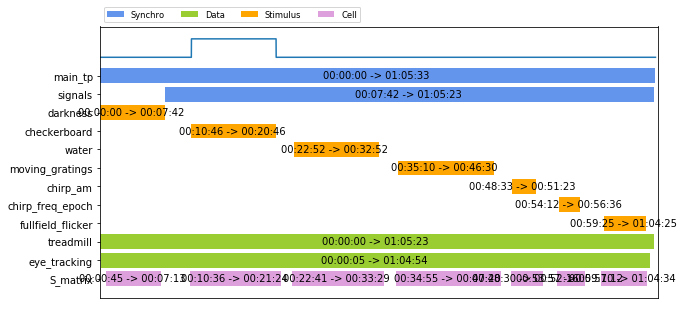

In [ ]:
pipe = Data_Pipe(reM, ["checkerboard", "eye_tracking", "S_matrix"], ["stim_inten", "eye_track", "spike_counts"])
pipe += "checkerboard"
reM.plot()
pipe.plot()

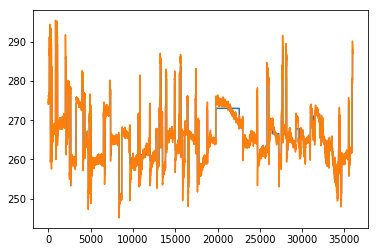

In [ ]:
eye_smooth = smooth_eye_position(pipe[0]["eye_track"], threshold=1)
plt.figure()
plt.plot(eye_smooth[:,0])
plt.plot(pipe[0]["eye_track"][:,0])

In [ ]:
stim_inten_corrected = eyetrack_stim_inten(pipe[0]["stim_inten"], pipe[0]["eye_track"])

In [ ]:
print(pipe[0]["stim_inten"].shape)
print(stim_inten_corrected.shape)

(36000, 15, 20)
(36000, 30, 40)


In [ ]:
#export
def process_sta_batch(stim_inten, spike_counts, Hw=30, Fw=2, return_pval=False):
    """Calculate the STA for a batch of cells."""
    #Preparing the stimulus
    orig_shape = stim_inten.shape
    stim_inten = stim_inten_norm(stim_inten)
    sum_spikes = np.sum(spike_counts, axis=0)
    len_stim = len(stim_inten)
    
    #We just have to calculate one STA over the whole record
    stim_inten   = np.reshape(stim_inten, (len(stim_inten),-1))
    stim_inten   = np.transpose(stim_inten)
    allCells_sta = staEst_fromBins(stim_inten, spike_counts, Hw, Fw=Fw)

    if len(orig_shape)==3:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw, orig_shape[-2], orig_shape[-1]))
    elif len(orig_shape)==2:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw,-1))
    else:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw))
        
    if allCells_sta.shape[0]==1: #Only one cell, but we need to keep the axis
        allCells_sta = np.squeeze(allCells_sta)
        allCells_sta = np.expand_dims(allCells_sta, axis=0)
    else:
        allCells_sta = np.squeeze(allCells_sta)
    
    if return_pval:
        p_values = np.empty(allCells_sta.shape)
    for k, cell_sta in enumerate(allCells_sta): #Easy way to do normalization for each cell that works for all possible shapes
        if return_pval:
            z_scores    = cell_sta/ np.sqrt(1/sum_spikes[k]) #Standard score is calculated as (x-mean)/std
            p_values[k] = sp.stats.norm.sf(abs(z_scores))*2*(len_stim-Hw) 
            
        allCells_sta[k] = np.nan_to_num(cell_sta/np.max(np.abs(cell_sta)))
        
    if return_pval:
        return allCells_sta, p_values
    else:
        return allCells_sta
    
def staEst_fromBins(stim, spike_counts, Hw, Fw=0):
    """Fw is the amount of frame after a spike that we calculate the average for.
        stim must be of shape (x*y,n_frame)
        spike_counts must be of shape (n_frame, n_cells)
        Return sta of all cells in the shape (n_cells, Hw+Fw, y*x) """
    spike_counts[:Hw] = 0
    
    spike_counts = np.nan_to_num(spike_counts / np.sum(spike_counts,axis=0))
    spike_counts = spike_counts - np.mean(spike_counts,axis=0)
    sta = np.zeros((Hw+Fw, stim.shape[0], spike_counts.shape[-1]))
    for i in range(Hw):
        sta[(Hw-1-i),:,:] = np.dot(stim, spike_counts)
        spike_counts = np.roll(spike_counts, -1, axis=0)
    spike_counts = np.roll(spike_counts, Hw, axis=0)
    if Fw != 0:
        spike_counts[-Fw:] = 0
    for i in range(Fw):
        spike_counts  = np.roll(spike_counts, 1, axis=0)
        sta[Hw+i,:,:] = np.dot(stim, spike_counts)
    spike_counts = np.roll(spike_counts, -Fw, axis=0)
    return np.transpose(sta, (2,0,1))

In [ ]:
result_sta = process_sta_batch(eyetrack_stim_inten(pipe[0]["stim_inten"], pipe[0]["eye_track"]), 
                               pipe[0]["spike_counts"], Hw=40)

In [ ]:
#Shape is (n_cell, Hw+Fw, y, x)
result_sta.shape

(2, 42, 30, 40)

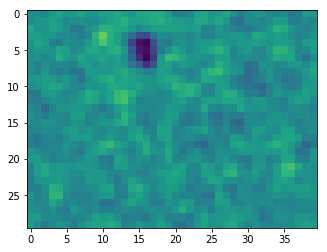

In [ ]:
cell_id = 0
plt.figure()
plt.imshow(result_sta[cell_id, -15], vmin=-1, vmax=1)

In [ ]:
#export
def cross_correlation(spike_counts, tail_len=50):
    """From `spike_counts` of shape (n_dpoints, n_cell), calculate the cross correlation
    of the cells over a window of `tail_len`*2 centered on the middle of the trace."""
    n_dpoints, n_cell = spike_counts.shape
    corr_arr = np.zeros((n_cell,n_cell,tail_len*2+1))
    spike_counts = (spike_counts / np.max(spike_counts, axis=0)) #Independant normalization of the cells
    spike_counts_edged = np.concatenate((np.zeros((tail_len,n_cell)), 
                    spike_counts, 
                    np.zeros((tail_len,n_cell)))) #Creating an array with 0 tails on both side to use the valid mode
                                                  # of numpy.correlate
    for i in range(n_cell):
        for j in range(i, n_cell):
            corr_arr[i,j] = np.correlate(spike_counts_edged[:,i],
                                         spike_counts[:,j], 
                                         mode="valid")
            corr_arr[j,i] = corr_arr[i,j]
    return corr_arr/n_dpoints

In [ ]:
pipe = Data_Pipe(reM, ["S_matrix"])
pipe += "checkerboard"
checker_corr = cross_correlation(pipe[0]["S_matrix"])

C:\Users\tombo\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


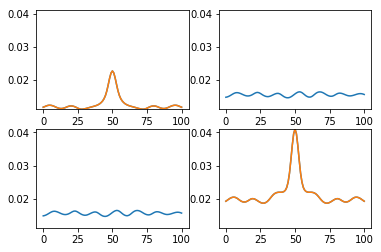

In [ ]:
n_cell = pipe[0]["S_matrix"].shape[1]
ymin, ymax = np.min(checker_corr), np.max(checker_corr)
for i in range(n_cell):
    for j in range(i, n_cell):
        plt.subplot(n_cell,n_cell,1+i*n_cell+j)
        plt.plot(checker_corr[i,j])
        plt.ylim([ymin,ymax])
        plt.subplot(n_cell,n_cell,1+j*n_cell+i)
        plt.plot(checker_corr[i,j])
        plt.ylim([ymin,ymax])

In [ ]:
#export
def corrcoef(spike_counts):
    return np.corrcoef(spike_counts.T)

def flatten_corrcoef(corrcoef_matrix):
    shp = corrcoef_matrix.shape
    return np.array([corrcoef_matrix[i,j] for i in range(shp[0]) for j in range(i+1, shp[0])])

In [ ]:
pipe = Data_Pipe(reM, ["S_matrix"])
pipe += "checkerboard"
corr = corrcoef(pipe[0]["S_matrix"])
print(corr)
print(flatten_corrcoef(corr))

[[1.         0.02712507]
 [0.02712507 1.        ]]
[0.02712507]


In [ ]:
#export
def stimulus_ensemble(stim_inten, Hw=30, x=0, y=0, w=None, h=None):
    stim_inten = stim_inten_norm(stim_inten)
    if w is None:
        w = stim_inten.shape[2]
    if h is None:
        h = stim_inten.shape[1]
    stim_ensmbl = np.zeros((len(stim_inten)-Hw, w*h*Hw))
    for i in range(Hw, len(stim_inten)):
        flat_stim         = np.ndarray.flatten(stim_inten[i-Hw:i,
                                                          y:y+h,
                                                          x:x+w])
        stim_ensmbl[i-Hw] = flat_stim
    return stim_ensmbl

def process_nonlinearity(stim_ensemble, spike_bins):
    """Stimulus must already have been converted to the stim_ensemble, so spike_bins must also
    not include the history window a the beggining."""
    assert len(stim_ensemble)==len(spike_bins)
    stim_ensmbl_mean  = np.mean(stim_ensemble,axis=0)#np.mean(spike_triggering_stimuli,axis=0)
    spike_ensmbl_mean = np.average(stim_ensemble, axis=0, weights=spike_bins)
    middle_vec = np.mean(np.stack((stim_ensmbl_mean, spike_ensmbl_mean)), axis=0)
    
    pca = PCA(n_components=2)
    fit = pca.fit(np.stack((stim_ensmbl_mean,
                            spike_ensmbl_mean,
                            middle_vec)))
    stim_ensemble_tranfo = fit.transform(stim_ensemble)
    
    if np.min(spike_bins)<1:#We have probabilities, not spike counts. Need to make it integers
        mask        = np.where(spike_bins > 0)[0]
        nonzero_min = np.min(spike_bins[mask])
        discretized = spike_bins/nonzero_min
        spike_bins  = ((10*discretized)/(np.max(discretized))).astype(int)
    spike_ensembl = []
    for n_spike, stim_transfo in zip(spike_bins, stim_ensemble_tranfo):
        spike_ensembl.extend([stim_transfo]*n_spike)
    
    xaxis      = np.linspace(np.min(stim_ensemble_tranfo),np.max(stim_ensemble_tranfo),101)
    hist_all   = np.histogram(stim_ensemble_tranfo, bins=xaxis)[0]
    hist_trigg = np.histogram(spike_ensembl, bins=xaxis)[0]
    
    nonlin = hist_trigg/hist_all
    
    nonlin = fill_nan(nonlin)
        
    return nonlin
        

C:\Users\tombo\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


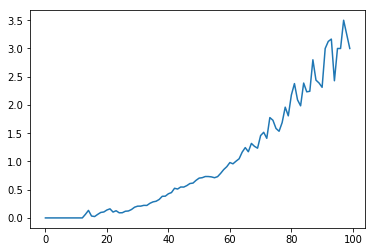

In [ ]:
pipe = Data_Pipe(reM, ["S_matrix"], ["spike_counts"])
pipe += "checkerboard"
checker_corr = cross_correlation(pipe[0]["spike_counts"])
stim_ensembl = stimulus_ensemble(stim_inten_corrected)
nonlin = process_nonlinearity(stim_ensembl, pipe[0]["spike_counts"][30:,0])
plt.figure()
plt.plot(nonlin)

In [ ]:
#export
def activity_histogram(spike_counts):
    flat_spikes = spike_counts.reshape(-1)
    flat_cell = np.array([[i]*spike_counts.shape[0] for i in range(spike_counts.shape[1])]).reshape(-1)
    hist = np.histogram2d(flat_spikes, flat_cell, bins=[100,spike_counts.shape[1]])[0] / spike_counts.shape[0]
    return hist

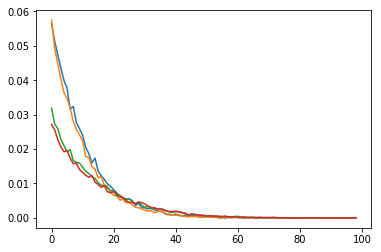

In [ ]:
pipe = Data_Pipe(reM, ["S_matrix"], ["spike_counts"])
pipe += "darkness"
pipe &= "S_matrix"
hist_dark = activity_histogram(pipe[0]["spike_counts"])

pipe = Data_Pipe(reM, ["S_matrix"], ["spike_counts"])
pipe += "water"
hist_water = activity_histogram(pipe[0]["spike_counts"])

plt.figure()
plt.plot(hist_dark[1:])
plt.plot(hist_water[1:])

In [ ]:
#export
def cross_distances(masks):
    """Compute cross distances from the center of mass of a list of mask. masks must be in shape (n_mask, y, x)"""
    center_mass = np.array([ndimage.measurements.center_of_mass(mask) for mask in masks])
    cross_distances = np.zeros((len(masks),len(masks)))
    for i in range(len(masks)):
        for j in range(i,len(masks)):
            cross_distances[i,j] = np.linalg.norm(center_mass[i]-center_mass[j])
            cross_distances[j,i] = cross_distances[i,j]
    return cross_distances

def cross_distances_sta(fits, sta_shape, f):
    sta_masks = np.array([img_2d_fit(sta_shape, fit, f) for fit in fits])
    for i,sta_mask in enumerate(sta_masks):
        if abs(np.min(sta_mask)) > np.max(sta_mask):
            sta_masks[i] = sta_mask < -.5
        else:
            sta_masks[i] = sta_mask > .5
    return cross_distances(sta_masks)

def paired_distances(masks_1, masks_2):
    """Compute paired distances from the center of mass of a list of mask. masks must be in shape (n_mask, y, x)"""
    center_mass_1 = np.array([ndimage.measurements.center_of_mass(mask) for mask in masks_1])
    center_mass_2 = np.array([ndimage.measurements.center_of_mass(mask) for mask in masks_2])
    paired_distances = np.zeros(len(masks_1))
    for i, (center_1, center_2) in enumerate(zip(masks_1, masks_2)):
        paired_distances[i] = np.linalg.norm(center_1-center_2)
    return paired_distances

def paired_distances_sta(sta_fits_1, sta_fits_2, sta_shape, f):
    sta_masks_1 = np.array([img_2d_fit(sta_shape, fit, f) for fit in sta_fits_1])
    for i,sta_mask in enumerate(sta_masks_1):
        if abs(np.min(sta_mask)) > np.max(sta_mask):
            sta_masks_1[i] = sta_mask < -.5
        else:
            sta_masks_1[i] = sta_mask > .5
    sta_masks_2 = np.array([img_2d_fit(sta_shape, fit, f) for fit in sta_fits_2])
    for i,sta_mask in enumerate(sta_masks_2):
        if abs(np.min(sta_mask)) > np.max(sta_mask):
            sta_masks_2[i] = sta_mask < -.5
        else:
            sta_masks_2[i] = sta_mask > .5
    return paired_distances(sta_masks_1, sta_masks_2)

In [ ]:
A_matrix = np.load(r".\files\vivo_2p\cells_spatial_matrix.npy")
cross_distances(A_matrix)

array([[  0.        , 318.55523926],
       [318.55523926,   0.        ]])

In [ ]:
#export
def direction_selectivity(grouped_spikes_d):
    """Compute the direction selectivity index of cells in the given dict containing for each condition as
    the keys, an array of shape (n_angle, n_repeat, trial_len, n_cell). Such dictionnary can be obtained
    by using utils.group_direction_response
    Return a dictionnary containing for each condition a tuple:
        - spike_sum: a sum of the spikes for each angle for each cell
        - dir_pref : an imaginary number of the prefered direction for each cell
        - the direction selectivity index of each cell"""
    
    res_d = {}
    for cond, sp_count in grouped_spikes_d.items():
        n_angle = sp_count.shape[0]
        mean_n_spike = np.sum(sp_count, axis=(1,2)).T

        x         = np.linspace(0, (n_angle-1)/4*np.pi, num=n_angle)

        #Direction selectivity
        vect_dir  = np.exp(x*1j)#np.array([np.cos(x) + np.sin(x)*1j])
        dir_pref  = np.nan_to_num((vect_dir * mean_n_spike).sum(axis=1) / mean_n_spike.sum(axis=1))
        ds_idx    = abs(dir_pref)

        #Orientation selectivity
        vect_ori  = np.exp(x*1j*2)#np.concatenate((vect_dir[:,:n_angle//2], vect_dir[:,:n_angle//2]), axis=1)
        ori_pref  = np.nan_to_num((vect_ori * mean_n_spike).sum(axis=1) / mean_n_spike.sum(axis=1))
        ori_idx   = abs(ori_pref)

        #Generating direction and orientation index from shuffled trials
        axtup_l = list(itertools.product(range(sp_count.shape[0]), range(sp_count.shape[1])))
        random.seed(1)
        n_shuffle = 1000
        axtup_l_shuffled = axtup_l.copy()
        rand_ori_idx_l = np.empty((n_shuffle, sp_count.shape[3]))
        rand_dir_idx_l = np.empty((n_shuffle, sp_count.shape[3]))
        for i in range(n_shuffle):
            random.shuffle(axtup_l_shuffled)
            shuffled_sp_count = np.empty(sp_count.shape)
            for axtup, axtup_shuff in zip(axtup_l, axtup_l_shuffled):
                shuffled_sp_count[axtup] = sp_count[axtup_shuff]
            rand_mean_n_spike      = np.sum(shuffled_sp_count, axis=(1,2)).T
            rand_dir_pref     = np.nan_to_num((vect_dir * rand_mean_n_spike).sum(axis=1) / rand_mean_n_spike.sum(axis=1))
            rand_dir_idx_l[i] = abs(rand_dir_pref)

            rand_ori_pref     = np.nan_to_num((vect_ori * rand_mean_n_spike).sum(axis=1) / rand_mean_n_spike.sum(axis=1))
            rand_ori_idx_l[i] = abs(rand_ori_pref)

        #Same calculation of pval as in Baden et al 2016
        p_val_dir = np.sum(rand_dir_idx_l<dir_pref, axis=0)/n_shuffle
        p_val_ori = np.sum(rand_ori_idx_l<ori_pref, axis=0)/n_shuffle

        #Finally we have to transform the orientation selectivity vectors to put them back in their
        # original orientation, by divinding the phase of the vector by two
        tau = np.pi*2
        polar_ori_pref = np.array(list((map(polar, ori_pref))))
        polar_ori_pref[:,1] = ((polar_ori_pref[:,1]+tau)%tau)/2 #Convert to positive radian angle and divide by two
        ori_pref = np.array([rect(pol[0], pol[1]) for pol in polar_ori_pref])

        res_d[cond] = (mean_n_spike, dir_pref, ds_idx, ori_pref, ori_idx, p_val_dir, p_val_ori)
        
    return res_d

In [ ]:
#export
def peri_saccadic_response(spike_bins, eye_tracking, motion_threshold=5, window=15):    
    eye_shifts = np.concatenate(([0],
                                 np.linalg.norm(eye_tracking[1:,:2]-eye_tracking[:-1,:2], axis=1)))
    
    #Because eye tracking is usually upsampled from 15 to 60Hz, it sums the shift, and smooth the peak
    # detection
    summed_shifts = np.convolve(eye_shifts, [1,1,1,1,1,1,1], mode="same")
    
    peaks, res = signal.find_peaks(eye_shifts, height=motion_threshold, distance=10)
    heights = res["peak_heights"] #Not used for now
    
    psr = np.zeros((window*2, spike_bins.shape[1]))
    for peak in peaks:
        if peak<window or (peak+window)>len(spike_bins):
            continue #Just ignoring peaks too close to the matrix edges
        psr += spike_bins[peak-window:peak+window]
    psr /= len(peaks)
    return psr

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 02_processing.ipynb.
Converted 03_modelling.ipynb.
Converted 04_plotting.ipynb.
Converted 05_database.ipynb.
Converted 10_synchro.io.ipynb.
Converted 11_synchro.extracting.ipynb.
Converted 12_synchro.processing.ipynb.
Converted 99_testdata.ipynb.
Converted index.ipynb.
